# Exploring venues in New Delhi, India

## Table of Contents

* [Introduction](#introduction)
* [Data Collection from APIs](#data_collection)
* [Data Cleaning](#data_cleaning)
* [Methodolgy](#methodology)
* [Analysis](#analysis)


## Introduction <a name="introduction"></a>

The aim of the project is to identify venues in New Delhi, India based on their rating and average prices. In this notebook, we will identify various venues in the city of **New Delhi, India**, using **Foursquare API** and **Zomato API**, to help visitors select the restaurants that suit them the best.

Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.

Here, we'll **identify places that are fit for various individuals** based on the information collected from the two APIs and Data Science. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.

## Data Collection from APIs <a name="data_collection"></a>

To begin with, we will take a look at **New Delhi on the Map** using the `folium` library.

We will also fetch the data from **two different APIs**.
* **Foursquare API:** We will use the Foursquare API to fetch venues in New Delhi starting from the middle upto 44 Kilometers in each direction.
* **Zomato API:** The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.

In [17]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [45]:
geolocator=Nominatim()
location=geolocator.geocode('New Delhi')
lat=location.latitude
lon=location.longitude
LATITUDE = lat
LONGITUDE = lon
print('The geograpical coordinates of New Delhi are {}, {}.'.format(LATITUDE, LONGITUDE))

C:\Users\rs24s\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """Entry point for launching an IPython kernel.


The geograpical coordinates of New Delhi are 28.6138954, 77.2090057.


Let's use the `folium` library to create a **complete map zoomed on Delhi**. We'll also plot a marker on the coordinates we just identified above. This would give us a relatively good look at the center point we will be considering. 

In [4]:
import folium

_map = folium.Map(location = [LATITUDE, LONGITUDE], zoom_start = 13)
folium.Marker([LATITUDE, LONGITUDE]).add_to(_map)

_map

### Foursquare API

We begin by fetching a total of all venues in **Delhi** upto a range of 4 Kilometers using the Foursquare API. The Foursquare API has the `explore` API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [5]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20200420' # Foursquare API version
RADIUS = 4000 # 4 Km
NO_OF_VENUES = 100
 # Current date

We define the `get_category_type` method to get the correct category for each venue.

In [6]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

* Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account. 
* We will set the radius as 4 Kilometers. 
* The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In [9]:
pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(CLIENT_ID, 
                                                                        CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        LATITUDE, 
                                                                        LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 4.0 Km
Total 87 venues fetched within a total radius of 4.0 Km

Total 187 venues fetched


In [10]:
result

{'meta': {'code': 200, 'requestId': '5f698ab8c121244092337564'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Delhi',
  'headerFullLocation': 'Delhi',
  'headerLocationGranularity': 'city',
  'totalResults': 187,
  'suggestedBounds': {'ne': {'lat': 28.649895436000037,
    'lng': 77.24993766995163},
   'sw': {'lat': 28.577895363999964, 'lng': 77.16807373004838}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '52e226ef498e7591ee3213db',
       'name': 'Chew',
       'location': {'address': 'M 16',
        'crossStreet': 'Connaught Place',
        'lat': 28.632001527203066,
        'lng': 77.22270642208512,
        'labeledLatLngs': [{'label': 'display',
          'lat': 28.632001

### Zomato API

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the `name`, `lat`, and `lng` values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

* The query will be the name of the venue.
* The start defines from what offset we want to start, so we'll keep it at 0.
* The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
* We will supply the latitude and longitude values.
* We will set the sorting criteria as `real_distance` so each time we get the venue we're searching based on location coordinates.

In [11]:
headers = {'user-key': 'b56c58d007880831306855381d077e18'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    try: 
        result = requests.get(url, headers = headers).json()
    except:
        print(row['name'])
        pass
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Indira Gandhi Memorial Museum | इंदिरा गांधी स्मारक संग्रहालय (Indira Gandhi Memorial Museum)
Fetching data for venue: 32
Fetching data for v

In [12]:
zomato_venues['latitude']=zomato_venues['latitude'].astype(float)
zomato_venues['longitude']=zomato_venues['longitude'].astype(float)
zomato_venues.head()

venue   latitude  longitude  \
0           Tamra - Shangri-La's - Eros Hotel  28.621105  77.216957   
1                             Kook For Health  28.626039  77.210866   
2                               Pandey's Paan  28.630727  77.217242   
3                              Social Affaire  28.645061  77.190262   
4  Nostalgia at 1911 Brasserie - The Imperial  28.625033  77.219077   

   price_for_two  price_range rating  \
0         3800.0          4.0    4.5   
1          500.0          2.0    3.9   
2          100.0          1.0    4.2   
3         2100.0          4.0    3.6   
4         6000.0          4.0    3.5   

                                             address  
0  Shangri-La's - Eros Hotel, 19, Level 1, Ashoka...  
1  1, Ashoka Road, Near Bangla Sahib Gurudwara, C...  
2  3, New MP's Market, Near RML Hospital, North A...  
3  17A/12, Ground Floor, Pusa Road, Near Metro Pi...  
4                   The Imperial, Janpath, New Delhi

## Data Cleaning <a name="data_cleaning"></a>

The data from multiple resources might not always align. Thus, it is **important to combine the data retrieved from multiple resources properly**.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [27]:
_map = folium.Map(location = [LATITUDE, LONGITUDE], zoom_start = 14)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(_map)  


_map

We will also plot the Zomato data on the map.

In [29]:
_map = folium.Map(location = [LATITUDE, LONGITUDE], zoom_start = 14)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(_map)  


_map

We can see that there are many venues identified by both Foursquare and Zomato. There is a lot of overlapping near Connaught Palace. However, there are others where the data does not match just like the red dots in the second map.

To combine the two datasets, I'll have to check that the latitude and longitude values of each corresponding venue match. Thus, I'll round both the latitude and longitude values upto 4 decimal places. Then, I'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [13]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [42]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [43]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

name  \
0                                        The Claridges   
1                                   The Big Chill Cafe   
2                                    Gulati Restaurant   
3                                HOTEL SARAVANA BHAVAN   
4                                 SODABOTTLEOPENERWALA   
5              Khan Market | खान मार्केट (Khan Market)   
6       Connaught Place | कनॉट प्लेस (Connaught Place)   
7                           Perch, Wine And Coffee Bar   
8                                     Smoke House Deli   
9                                   Naturals Ice Cream   
10                                           Starbucks   
11                                        Amour Bistro   
12                               HOTEL SARAVANA BHAVAN   
13                                               Perch   
14                                         Khan Chacha   
15                                       Wenger's Deli   
16                                       Public Affair   
17       Bengali Market | बंगाली मार्केट | বাংলা বাজার   
18                                Triveni Terrace Cafe   
19                                            Havemore   
20                                        Odeon Social   
21                                            Sanadige   
22                                          Farzi Cafe   
23                               Full Circle Bookstore   
24                         The Square, Cafe Coffee Day   
25                                         Sagar Ratna   
26                                             Nando's   
27                                      Warehouse Cafe   
28                                       Pind Balluchi   
29                                             Chaayos   
30                                          The Oberoi   
31                                           Unplugged   
32                   Khan Chacha | खान चाचा | خان چاچا   
33                                      Warehouse Cafe   
34                                           Al Kauser   
35              Nizam's Kathi Kabab | निजा़म काठी कबाब   
36                                     The Lodhi Hotel   
37                                 United Coffee House   
38                                       Indian Accent   
39             Triveni Kala Sangam | त्रिवेणी कला संगम   
40   Sriram Centre For Art And Culture | श्रीराम कल...   
41              Immigrants Project - A Cafe in History   
42                                      Lázeez Affaire   
43                                            Route 04   
44                              Panchayat Paan Parlour   
45                               Janpath Street Market   
46                                       The Beer Cafe   
47                                  The Drunkyard Cafe   
48                                         Diva Spiced   
49                                     Barbeque Nation   
50                                 Nathu's Pastry Shop   
51                                     Veda Restaurant   
52                                                Chew   
53              bloomrooms @ New Delhi Railway Station   
54                  Sita Ram Diwan Chand Chole Bhature   
55                           Old Rajender nagar market   
56              The Oberoi Patisserie and Delicatessen   
57                                             Sidewok   
58                                    Élan @ The Lodhi   
59                                      Odeon Pan Shop   
60                                               Tadka   
61                                              Subway   
62                    Madras Coffee House (since 1935)   
63                                        Masala House   
64                                    Chimney Sizzlers   
65                                  Kwality Restaurant   
66                         The Indian Grill Restaurant   
67                                      FEZ Restaurant   
68                                              

Taking a look at the names of venues from both APIs, some names are a complete mismatch.

**Category 1:** There are venues that have specific restaurants/cafes inside them as provided by Zomato API (Cafe Coffee Day in Connaught Place, XO Cafe in bloomrooms).

**Category 2:** Two locations are so close by that they have practically same latitude and longitude values but no relation in venue and name.

**Category 3:** Some have been replaced with new restaurants (My Bar has now been replaced by White Heart Restro Bar	).

The venues which belong to category 1 and category 3 are alright to keep, the venues that fall in category 2 should be removed.

In [24]:
rem=[7,8,14,23,26,46,48,50,64,78,86,92,101]
selected_venues=selected_venues.drop(rem,axis=0)
selected_venues.drop_duplicates(['name','lat','lng'],inplace=True)
selected_venues.reset_index(inplace=True)




I'll now select the venue name from **Zomato API**. I'll also get the average price per person by dividing the column `price_for_two` by 2 and removing this column from the dataset along with other unnecessary columns.

In [ ]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [47]:
selected_venues=pd.read_csv('Selected venues.csv')
selected_venues = selected_venues.drop(columns = ['Unnamed: 0'])
selected_venues.head()

categories                      venue  latitude  longitude  \
0                    Hotel  Pickwicks - The Claridges   28.6006    77.2170   
1       Italian Restaurant              The Big Chill   28.6007    77.2278   
2        Indian Restaurant                     Gulati   28.6080    77.2301   
3  South Indian Restaurant            Saravana Bhavan   28.6272    77.2197   
4               Irani Cafe       SodaBottleOpenerWala   28.5999    77.2261   

   price_range  rating                                            address  \
0          4.0     3.8  The Claridges, 12, Dr. A.P.J. Abdul Kalam Road...   
1          3.0     4.9                       68-A, Khan Market, New Delhi   
2          4.0     4.5                  6, Pandara Road Market, New Delhi   
3          2.0     4.5            50, Atul Grove Road, Janpath, New Delhi   
4          3.0     4.4                         73, Khan Market, New Delhi   

   average_price rating_bin  
0         1800.0       Good  
1          750.0  Very good  
2         1250.0  Very good  
3          250.0  Very good  
4          650.0  Very good

Let's take a look at the final dataset that is left with us.

I'll drop the venues which have `0.0` rating as it means it's not been rated yet.

In [42]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 88


## Methodology <a name="methodology"></a>

This project aims at identifying the venues in Delhi based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, we retrieved the **data from two APIs (Foursquare and Zomato)**. We extract venue information from the center of New Delhi, upto a distance of 4 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we then **explored the data** retrieved from the two APIs on the map and identified the top category types. The **data from the two sources is carefully combined** based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll **analyse the data** that we created based on the ratings and price of each venue. We'll **identify places where many venues are located** so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore **areas that are high rated and those that are low rated** while also plotting the **map of high and low priced venues**. Lastly, we'll **cluster the venues** based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

## Analysis <a name="analysis"></a>

The complete dataset is now in its final form. 

We will **inspect these venues based on their rating**. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also **analyse the venues based on their price per person as well as the price range**. 

### Categories

We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 36 artists>

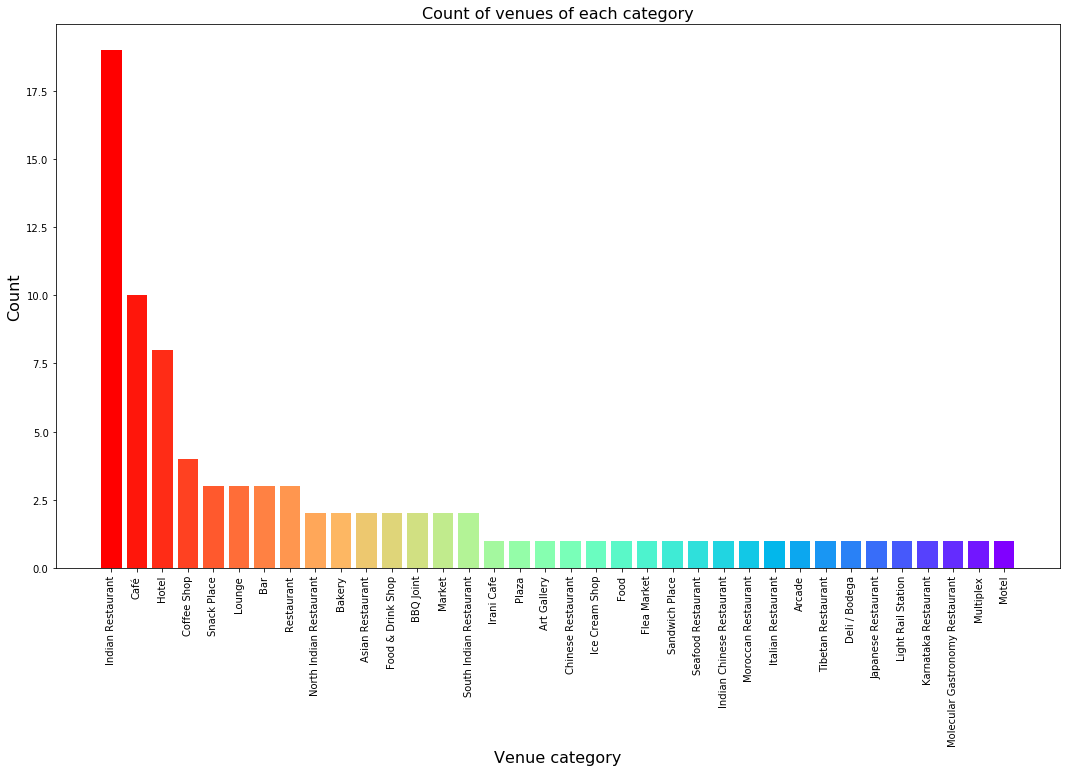

In [18]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(1, 0, len(venue_distribution.index)))
plt.figure(figsize = (18, 10))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can see the majority venues are **Indian Restaurant** and **Cafe**. So, if as a tourist, you're looking for cafes and Indian restaurants, you're in luck.

### Rating

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

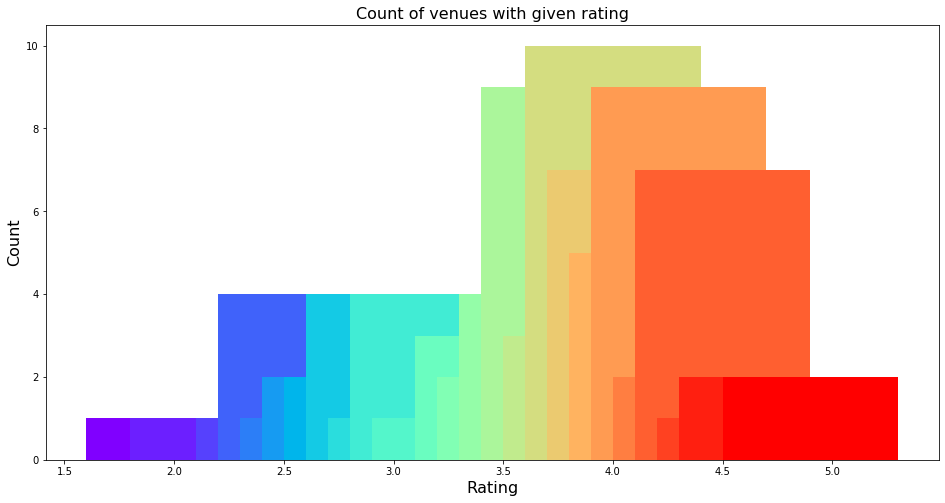

In [19]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (16, 8))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that **majority venues** have their **rating close to 4**.

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:
* 1 to 2
* 2 to 3
* 3 to 4
* 4 to 5

In [20]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Now, we will plot the venues on the map.

In [124]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

delhi_map = folium.Map(location = [LATITUDE, LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(delhi_map)  


delhi_map

The map has the location of all the venues. It appears that many venues are located near about **Connaught Palace** and **Rajiv Chok**  with rating above 3. If someone wants to explore new venues, they should definitely check out Rajiv Chok

### Price

We will now take a look the venues based on the price values. We have two price features for our venues, one is `average_price` which defines the average cost for one person and the other is `price_range` which determines the price range as defined by Zomato.

We will first explore the `average_price` using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

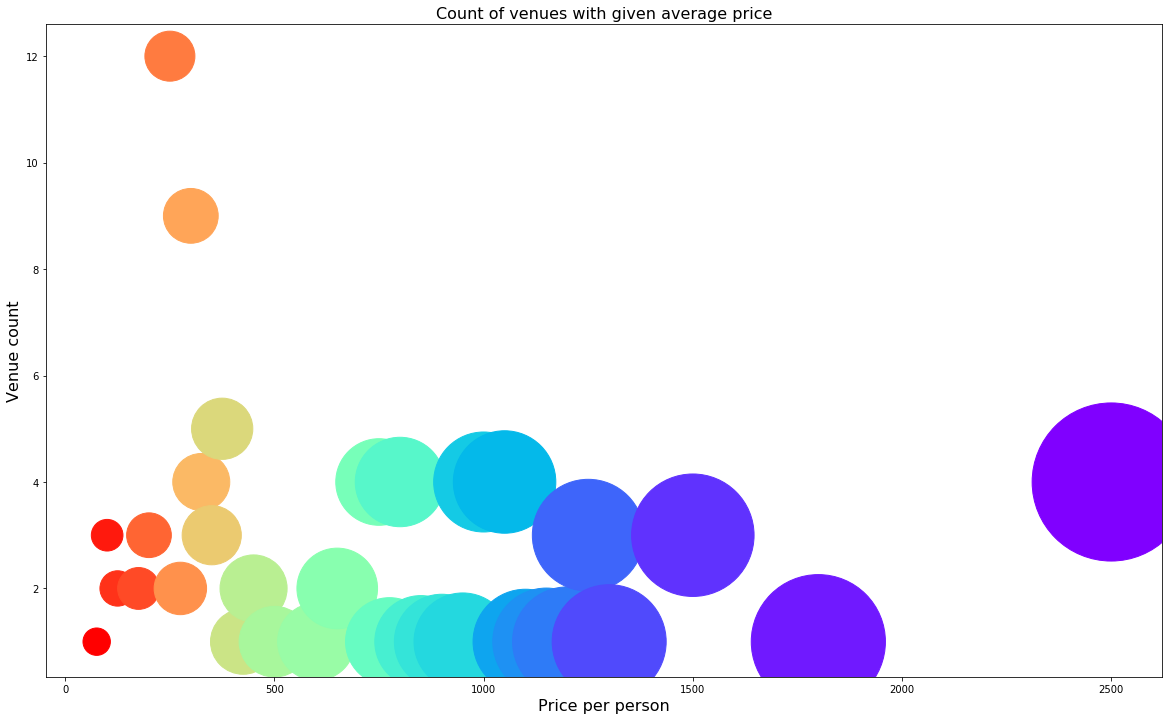

In [21]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(1, 0, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot above we can see that a large number of venues have an average price between Rs 200 and Rs 400.

Users might also be interested in going to a place that fits in their budget. I'll use the `price_range` column to plot the venues on a map. We'll represent the venues with lower price in green and move towards red as the price increases.

In [113]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

delhi_map = folium.Map(location = [LATITUDE, LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(delhi_map)  


delhi_map

1. The venues near Karol Bagh and Paharngaj are primarily lower priced.
2. The venues near Khan Market have steep prices.
3. Rajiv Chowk seems to have a mix of both high priced and low priced venues.

### Clustering

We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into three separate groups.

In [43]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 3

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

cluster_labels               categories                      venue  \
0               2                    Hotel  Pickwicks - The Claridges   
1               1       Italian Restaurant              The Big Chill   
2               1        Indian Restaurant                     Gulati   
3               0  South Indian Restaurant            Saravana Bhavan   
4               0               Irani Cafe       SodaBottleOpenerWala   

   latitude  longitude  price_range  rating  \
0   28.6006    77.2170          4.0     3.8   
1   28.6007    77.2278          3.0     4.9   
2   28.6080    77.2301          4.0     4.5   
3   28.6272    77.2197          2.0     4.5   
4   28.5999    77.2261          3.0     4.4   

                                             address  average_price rating_bin  
0  The Claridges, 12, Dr. A.P.J. Abdul Kalam Road...         1800.0       Good  
1                       68-A, Khan Market, New Delhi          750.0  Very good  
2                  6, Pandara Road Market, New Delhi         1250.0  Very good  
3            50, Atul Grove Road, Janpath, New Delhi          250.0  Very good  
4                         73, Khan Market, New Delhi          650.0  Very good

In [46]:
delhi_map = folium.Map(location = [LATITUDE, LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red',2:'blue'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(delhi_map)



delhi_map

From the map, we see the three clusters:
1. The first cluster is spread across the whole city and includes the majority venues.
2. The second cluster venues have good rating and mid range price.
3. The third cluster is very sparsely spread and has very limited venues with high price range.


I'll also check the venues of the three clusters.

In [128]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(15).reset_index(drop = True)

Cluster 0


cluster_labels  index               categories  \
0                0      3  South Indian Restaurant   
1                0      4               Irani Cafe   
2                0      5                   Market   
3                0      6                    Plaza   
4                0      9           Ice Cream Shop   
5                0     10              Coffee Shop   
6                0     12  South Indian Restaurant   
7                0     15            Deli / Bodega   
8                0     17        Indian Restaurant   
9                0     18                     Café   
10               0     20                     Café   
11               0     24                     Café   
12               0     25        Indian Restaurant   
13               0     28  North Indian Restaurant   
14               0     29                     Café   

                           venue  latitude  longitude  price_range  rating  \
0                Saravana Bhavan   28.6272    77.2197          2.0     4.5   
1           SodaBottleOpenerWala   28.5999    77.2261          3.0     4.4   
2     The Coffee Bean & Tea Leaf   28.6002    77.2268          2.0     4.0   
3                Cafe Coffee Day   28.6330    77.2197          2.0     2.6   
4              Natural Ice Cream   28.6344    77.2220          1.0     4.7   
5               Starbucks Coffee   28.6322    77.2178          2.0     4.2   
6                Saravana Bhavan   28.6323    77.2166          2.0     4.6   
7                  Wenger's Deli   28.6337    77.2183          2.0     4.7   
8      Bengali Sweets And Snacks   28.6295    77.2320          2.0     3.5   
9           Triveni Terrace Cafe   28.6274    77.2324          1.0     4.5   
10       Odeon Gupta Paan Palace   28.6342    77.2209          1.0     4.0   
11  Cafe Coffee Day - The Square   28.6268    77.2195          2.0     3.3   
12                   Sagar Ratna   28.6354    77.2205          2.0     3.9   
13                 PIND BALLUCHI   28.6304    77.2176          3.0     4.0   
14      Chaayos - Meri Wali Chai   28.6316    77.2203          2.0     4.2   

                                              address  average_price  \
0             50, Atul Grove Road, Janpath, New Delhi          250.0   
1                          73, Khan Market, New Delhi          650.0   
2             62, Middle Lane, Khan Market, New Delhi          350.0   
3   Gate 7, Rajiv Chowk Metro Station, Connaught P...          250.0   
4   L-8, L Block, Outer Circle, Connaught Place, N...          175.0   
5   A-1, Hamilton House, Inner Circle, Connaught P...          300.0   
6   P-13, Connaught Circus, Connaught Place, New D...          250.0   
7       A 18, Radial Road, Connaught Place, New Delhi          250.0   
8       34-37, Bengali Market, Mandi House, New Delhi          250.0   
9   205, Tansen Marg, Opposite FICCI Auditorium, M...          200.0   
10             1, D Block, Connaught Place, New Delhi          100.0   
11       44, Near Atul Grove Road, Janpath, New Delhi          350.0   
12                   K-15, Connaught Place, New Delhi          375.0   
13     13, Regal Building, Connaught Place, New Delhi          650.0   
14  F-14/15, 1st Floor, Mezzanine, F Block, Inner ...          250.0   

   rating_bin  
0   Very good  
1   Very good  
2        Good  
3        Okay  
4   Very good  
5   Very good  
6   Very good  
7   Very good  
8        Good  
9   Very good  
10       Good  
11       Good  
12       Good  
13       Good  
14  Very good

In [137]:
print("These venues for cluster 0 have mean price range of {:.02f} , rating spread around {:.02f} and average price is around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean(),result['average_price'].mean()))

These venues for cluster 0 have mean price range of 1.87 , rating spread around 3.64 and average price is around 297.64


In [136]:
result['average_price'].mean()

297.64150943396226

In [138]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(15).reset_index(drop = True)

Cluster 1


cluster_labels  index                       categories  \
0                1      1               Italian Restaurant   
1                1      2                Indian Restaurant   
2                1     11                             Café   
3                1     13                             Café   
4                1     16                           Lounge   
5                1     19                Indian Restaurant   
6                1     21             Karnataka Restaurant   
7                1     22  Molecular Gastronomy Restaurant   
8                1     27                           Lounge   
9                1     30                            Hotel   
10               1     31                           Lounge   
11               1     33                             Café   
12               1     37                Indian Restaurant   
13               1     41                             Café   
14               1     42                Indian Restaurant   

                                                venue  latitude  longitude  \
0                                       The Big Chill   28.6007    77.2278   
1                                              Gulati   28.6080    77.2301   
2                                        Amour Bistro   28.6016    77.1860   
3                             Perch Wine & Coffee Bar   28.5999    77.2263   
4                                       Public Affair   28.5999    77.2266   
5                                            Havemore   28.6081    77.2297   
6                                          Sana-Di-Ge   28.6019    77.1871   
7                                          Farzi Cafe   28.6325    77.2212   
8                                      Warehouse Cafe   28.6338    77.2210   
9   The Oberoi Patisserie and Delicatessen - The O...   28.5962    77.2397   
10                                Unplugged Courtyard   28.6342    77.2215   
11                                     Warehouse Cafe   28.6338    77.2210   
12                                United Coffee House   28.6325    77.2211   
13                                 The Immigrant Cafe   28.6342    77.2189   
14                                     Lazeez Affaire   28.6022    77.1860   

    price_range  rating                                            address  \
0           3.0     4.9                       68-A, Khan Market, New Delhi   
1           4.0     4.5                  6, Pandara Road Market, New Delhi   
2           4.0     4.3  10/48, Malcha Marg Shopping Complex, Chanakyap...   
3           4.0     4.5              71, 1st Floor, Khan Market, New Delhi   
4           4.0     4.2  67-68, 1st & 2nd Floor, Middle Lane, Khan Mark...   
5           4.0     4.3              11-12, Pandara Road Market, New Delhi   
6           4.0     4.3  22/48, Commercial Centre, Malcha Marg, Chanaky...   
7           4.0     4.5  38/39, Level 1, Block E, Inner Circle, Connaug...   
8           4.0     4.3  D 19/20, D Block, Inner Circle, Near Rajiv Cho...   
9           4.0     3.8      The Oberoi, Dr. Zakir Hussain Marg, New Delhi   
10          3.0     4.2  23/7, L Block, Middle Circle, Connaught Place,...   
11          4.0     4.3  D 19/20, D Block, Inner Circle, Near Rajiv Cho...   
12          4.0     4.1                   E-15, Connaught Place, New Delhi   
13          3.0     4.1  B 45, 1st Floor, Inner Circle, Connaught Place...   
14          4.0     4.3  6/48, Malcha Marg Market, Chanakyapuri, New Delhi   

    average_price rating_bin  
0           750.0  Very good  
1          1250.0  Very good  
2          1000.0  Very good  
3          1000.0  Very good  
4          1050.0  Very good  
5          1150.0  Very good  
6          1100.0  Very good  
7          1250.0  Very good  
8          1050.0  Very good  
9          1500.0       Good  
10          800.0  Very good  
11         1050.0  Very good  
12         1250.0  Very good  
13          800.0  Very good  
14         1300.0  Very good

In [139]:
print("These venues for cluster 0 have mean price range of {:.02f} , rating spread around {:.02f} and average price is around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean(),result['average_price'].mean()))

These venues for cluster 0 have mean price range of 3.60 , rating spread around 4.10 and average price is around 1029.17


In [140]:
result = selected_venues[selected_venues['cluster_labels'] == 2]
print("Cluster 2")
result.head(10).reset_index(drop = True)

Cluster 2


cluster_labels  index           categories  \
0               2      0                Hotel   
1               2     36                Hotel   
2               2     38    Indian Restaurant   
3               2     58           Restaurant   
4               2     84  Japanese Restaurant   

                                   venue  latitude  longitude  price_range  \
0              Pickwicks - The Claridges   28.6006    77.2170          4.0   
1          The Electric Room - The Lodhi   28.5915    77.2381          4.0   
2                          Indian Accent   28.5921    77.2377          4.0   
3          The Electric Room - The Lodhi   28.5915    77.2381          4.0   
4  Sakura - The Metropolitan Hotel & Spa   28.6313    77.2083          4.0   

   rating                                            address  average_price  \
0     3.8  The Claridges, 12, Dr. A.P.J. Abdul Kalam Road...         1800.0   
1     2.6                   The Lodhi, Lodhi Road, New Delhi         2500.0   
2     4.9                   The Lodhi, Lodhi Road, New Delhi         2500.0   
3     2.6                   The Lodhi, Lodhi Road, New Delhi         2500.0   
4     3.8  The Metropolitan Hotel & Spa, Bangla Sahib Roa...         2500.0   

  rating_bin  
0       Good  
1       Okay  
2  Very good  
3       Okay  
4       Good

In [141]:
print("These venues for cluster 0 have mean price range of {:.02f} , rating spread around {:.02f} and average price is around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean(),result['average_price'].mean()))

These venues for cluster 0 have mean price range of 4.00 , rating spread around 3.54 and average price is around 2360.00
